In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim
import numpy as np
import torchvision.models as torch_models
from dataloader import RetinopathyLoader, getData
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Load Data

In [4]:
train_data = RetinopathyLoader('new_train', 'train')
test_data = RetinopathyLoader('new_test', 'test')
train_data = DataLoader(train_data, batch_size=16, shuffle=True)
test_data = DataLoader(test_data, batch_size=16, shuffle=False)
print(type(train_data))
print(len(train_data))
print(train_data)

> Found 28099 images...
> Found 7025 images...
<class 'torch.utils.data.dataloader.DataLoader'>
7025


## ResNet Model

In [5]:
class Pretrained_ResNet18(nn.Module):
    def __init__(self):
        
        super(Pretrained_ResNet18,self).__init__()
        
        # ResNet model from torchvision 
        self.model = models.resnet18(pretrained=True)
        
        # The number of output neuron of the last fc layer        
        
        num_features = self.model.fc.in_features
        
        # Replace the fc layer
        self.model.fc = nn.Linear(num_features, 5)
        
        
    def forward(self, x):
        x = self.model(x)
        return x

In [6]:
train_acc = []
test_acc = []

In [7]:
train_acc_2 = []
test_acc_2 = []

## Training

In [ ]:
model = Pretrained_ResNet18()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
loss_function = torch.nn.CrossEntropyLoss()


for epoch in range(6):
    
    print("---------{}th epoch---------".format(epoch+1))
    
    model.train()
    train_loss = 0.0
    correct = 0
    
    for i, (data, label) in enumerate(tqdm(train_data)):
        
        label = label.type(torch.LongTensor)
        data = data.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
        correct += (output.argmax(dim=1) == label).sum().item()
        train_loss += loss.item()
    
    
    print("Accuracy: ")
    print(correct/28099)
    print("Training Loss: ")
    print(train_loss)
    train_acc.append(correct/28099)
    
    model.eval()
    with torch.no_grad():
        
        max_acc = 0
        correct = 0
        
        for i, (data, label) in enumerate(tqdm(test_data)):
            
            label = label.type(torch.LongTensor)
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            
            correct += (output.argmax(dim=1) == label).sum().item()
        
        print("Testing Accuracy: ")
        print(correct/7025)
        test_acc.append(correct/7025)
        
        if((correct/7025)>=max_acc):
            max_acc=correct/7025
            torch.save(model, 'best_model.pt')

## Plot Accuracy Curve

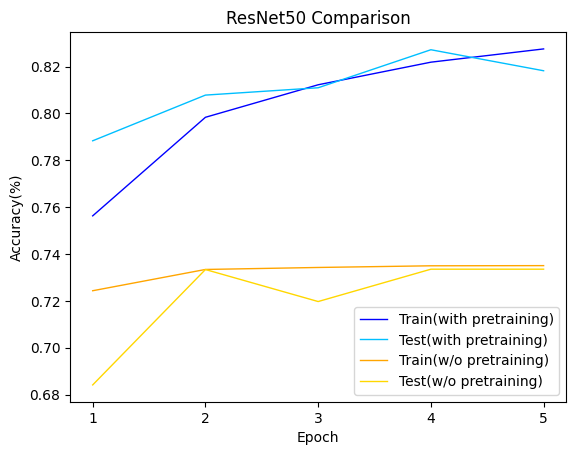

In [30]:
x_axis = list(range(1, 6))
plt.title('ResNet50 Comparison')
plt.plot(x_axis, train_acc, color='blue',linewidth=1.0, label='Train(with pretraining)')
plt.plot(x_axis, test_acc, color='deepskyblue',linewidth=1.0, label='Test(with pretraining)')
plt.plot(x_axis, train_acc_2, color='orange',linewidth=1.0, label='Train(w/o pretraining)')
plt.plot(x_axis, test_acc_2, color='gold',linewidth=1.0, label='Test(w/o pretraining)')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.xticks(x_axis)
plt.show()

## Evaluation

In [22]:
model = torch.load('best_model.pt')
model.eval()
with torch.no_grad():
    
    correct = 0
    confusion_matrix=np.zeros((5, 5))
    
    for i, (data, label) in enumerate(tqdm(test_data)):
        
        label = label.type(torch.LongTensor)
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        
        correct += (output.argmax(dim=1) == label).sum().item()
        
        for i, l in enumerate(label):
            confusion_matrix[int(l)][int(output[i].argmax())] += 1
    
    confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
    print(confusion_matrix)
    acc = correct/7025
    print("Testing Accuracy: ")
    print(acc)

100%|██████████| 1757/1757 [09:21<00:00,  3.13it/s]

[[0.97690666 0.00562779 0.01241995 0.         0.0050456 ]
 [0.72745902 0.18647541 0.07991803 0.         0.00614754]
 [0.34103512 0.1155268  0.49907579 0.00184843 0.04251386]
 [0.01714286 0.01714286 0.78285714 0.09714286 0.08571429]
 [0.17322835 0.         0.27559055 0.03149606 0.51968504]]
Testing Accuracy: 
0.818220640569395


## Plot Confusion Matrix

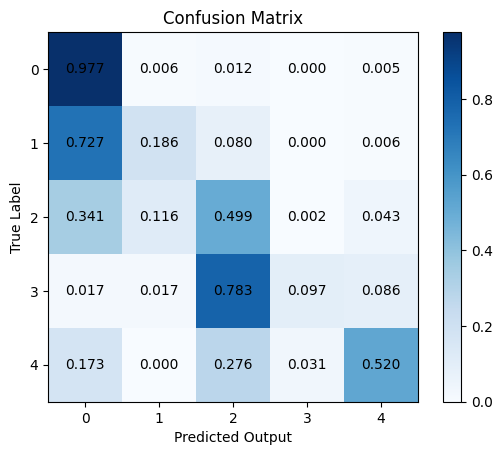

In [24]:
plt.imshow(confusion_matrix, cmap='Blues')


for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], '.3f'), ha="center", va="center", color="black")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Output")
plt.ylabel("True Label")
plt.colorbar()

plt.show()